<a href="https://colab.research.google.com/github/mkuczynski11/micropython-tflite/blob/notebooks_update/detection_model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports



In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

### Setup training and validation datasets

In [ ]:
batch_size = 32
img_height = 96
img_width = 96
# Use ready cnn architecture to detect image features
cnn_feature_vector = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5"
quantization = 'float' # Possible ['none', 'dynamic', 'float', 'int']

In [ ]:
# Usage of google drive where we are storing our data
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = '/content/gdrive/MyDrive/veh_detection' # directory of your data
!rm -rf /content/gdrive/MyDrive/veh_detection/.ipynb_checkpoints/


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 17770 files belonging to 2 classes.
Using 14216 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 17770 files belonging to 2 classes.
Using 3554 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['non-vehicles', 'vehicles']


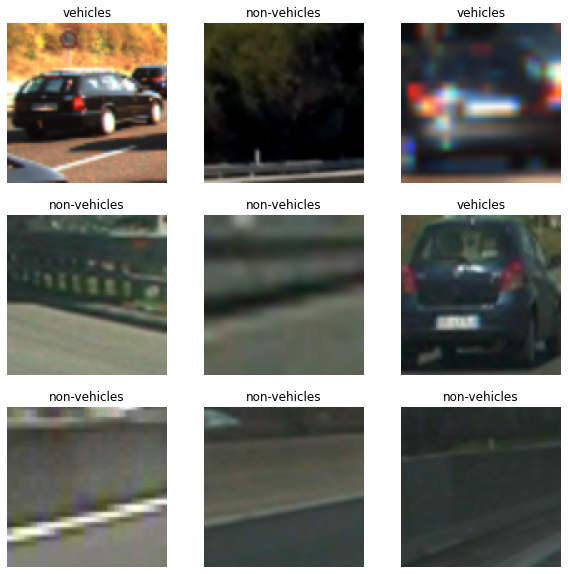

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Define model

In [ ]:
import tensorflow_hub as hub

num_classes = len(class_names)

# Name model with used architecture
model_name = cnn_feature_vector.split('/')[5]
print(model_name)
model_dir = pathlib.Path(f'/tmp/models/{model_name}')
model_dir.mkdir(exist_ok=True, parents=True)
print(model_dir)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    hub.KerasLayer(cnn_feature_vector, trainable=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mobilenet_v2_100_96
/tmp/models/mobilenet_v2_100_96


### Train model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

base_model_path = 'model.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    base_model_path,
    save_best_only=True
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)
# Also add epochs that model has been trained on
import sys
original_stdout = sys.stdout # Save a reference to the original standard output
with open(f'{model_dir}/{model_name}.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model.summary()
    sys.stdout = original_stdout # Reset the standard output to its original value

Epoch 1/20
445/445 [==============================] - 2658s 6s/step - loss: 0.0285 - accuracy: 0.9904 - val_loss: 0.0077 - val_accuracy: 0.9977
Epoch 2/20
445/445 [==============================] - 128s 286ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.0060 - val_accuracy: 0.9983
Epoch 3/20
445/445 [==============================] - 134s 300ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0051 - val_accuracy: 0.9980
Epoch 4/20
445/445 [==============================] - 122s 274ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0046 - val_accuracy: 0.9980
Epoch 5/20
445/445 [==============================] - 122s 274ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0054 - val_accuracy: 0.9980
Epoch 6/20
445/445 [==============================] - 126s 283ms/step - loss: 7.8055e-04 - accuracy: 0.9999 - val_loss: 0.0049 - val_accuracy: 0.9983
Epoch 7/20
445/445 [==============================] - 122s 272ms/step - loss: 5.6541e-04 - accuracy: 1.0000 - val_loss: 0.

### Convert to tflite

In [ ]:
def representative_data_gen():
  a = []
  limit = 3
  counter = 0
  for batch in train_ds:
    counter += 1
    if counter == 3:
      break
    input_tensor = batch[0]
    for i in range(input_tensor.shape[0]):
      a.append(input_tensor[i])
  a = np.asarray(a)
  ds = tf.data.Dataset.from_tensor_slices(a).batch(1)
  for i in ds.take(100):
    yield [i]

def write_to_file(text):
  with open(f'{model_dir}/{model_name}.txt', 'a') as f:
    f.write(text + '\n')

def no_quantization(converter):
  write_to_file('quantization: none')
  return converter.convert()

# Smaller model with quantized weights, but other variable data still in float format
# NOTE: Hybrid models are not supported in TFlite Micro
def dynamic_quantization(converter):
  write_to_file('quantization: dynamic')
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  return converter.convert()

# All weights and variable data quantized
# Not compatible with devices that perform only integer-based operations 
def float_quantization(converter):
  write_to_file('quantization: float')
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  return converter.convert()

# All weights and variable data quantized
# Internal quantization is the same as with float, but inuput and output tensors format is changed to uint8
def int_quantization(converter):
  write_to_file('quantization: int')
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  # Ensure that if any ops can't be quantized, the converter throws an error
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  # Set the input and output tensors to uint8 (APIs added in r2.3)
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  return converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
if quantization == 'none':
  tflite_model = no_quantization(converter)
elif quantization == 'dynamic':
  tflite_model = dynamic_quantization(converter)
elif quantization == 'float':
  tflite_model = float_quantization(converter)
elif quantization == 'int':
  tflite_model = int_quantization(converter)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### Check model accuracy

In [ ]:
loss, acc = model.evaluate(val_ds)
write_to_file(f'loss={loss}, accuracy={acc}')

112/112 [==============================] - 25s 223ms/step - loss: 0.0048 - accuracy: 0.9983


### Save model

In [ ]:
import pathlib

model_save_name = f'{model_name}.tflite'

tflite_model_file = model_dir/model_save_name
tflite_model_file.write_bytes(tflite_model)

with open(f'{model_dir}/labels.txt', 'a') as f:
    for class_name in train_ds.class_names:
      f.write(class_name + '\n')


### Test model

[0.22265625 0.77734375]
1


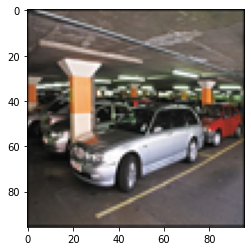

In [ ]:
# # Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Load image
import urllib.request
import numpy as np
from PIL import Image

urllib.request.urlretrieve(
  'https://popcenter.asu.edu/sites/default/files/problems/parking_garage_theft/images/cartheft2.jpg',
   "gfg.jpg")
image = Image.open('gfg.jpg').resize((96,96))
image = np.asarray(image)
image = image.reshape((96, 96, 3))

test_image = np.expand_dims(image, axis=0).astype(input_details["dtype"])
interpreter.set_tensor(input_details['index'], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details['index'])[0]
print(output)
print(output.argmax())

import matplotlib.pylab as plt

plt.imshow(image)

im = Image.fromarray(image)
im.save('veh.jpg')